## <font color='red'>0.0. Imports</font> 

### 0.1. Libs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn import metrics as m
from plotly import express as px


### 0.2. Load data

In [2]:
# Load the dataset
df_raw = pd.read_csv('../data/Ecommerce.csv', sep=',', encoding='latin1')

# drop the 'Unnamed: 8' column
df_raw.drop(columns=['Unnamed: 8'], inplace=True)


In [3]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color='red'>1.0. Descrição dos Dados</font> 

In [5]:
df1 = df_raw.copy()

### 1.1. Renomeando Colunas

In [6]:
df1.columns = new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
357598,568101,23340,VINTAGE CHRISTMAS CAKE FRILL,24,21-Sep-17,1.65,15978.0,United Kingdom


### 1.2. Dimensão dos Dados


In [7]:
print(f'Total de linhas:{df1.shape[0]}')
print(f'Total de colunas:{df_raw.shape[1]}')

Total de linhas:541909
Total de colunas:8


### 1.3. Tipo dos Dados

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4. Verificando dados nulos

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5. Substituindo dados nulos

In [10]:
# Remove rows with NaN values in 'customer_id' and 'description'
df1 = df1.dropna(subset=['customer_id', 'description'])

# proportion of NaN values in 'customer_id' and 'description'
print(f'Dados removidos: { ( 1 - ( df1.shape[0] / df_raw.shape[0] ) ) * 100:.2f}%')

Dados removidos: 24.93%


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.6. Alterando tipo os dados

In [12]:
# invoice_date to datetime
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id to int
df1['customer_id'] = df1['customer_id'].astype( int )

print(f'{df1.dtypes}\n')
df1.head()

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object



,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


### 1.7. Estatística Descritiva

## <font color='red'>02. Feature Engineering</font> 

In [13]:
df2 = df1.copy()

In [14]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


### Criação de features

In [15]:
df_ref = df2[['customer_id']].drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [16]:
# Faturamento por cliente
df2['gros_revenue'] = df2['quantity'] * df2['unit_price']
df_m = df2[['customer_id', 'gros_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_m, on='customer_id', how='left')


# Recencia
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recence_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_ref = df_ref.merge(df_recency[['customer_id', 'recence_days']], on='customer_id', how='left')

# Frequencia
df_freq = df2[['customer_id','invoice_no']].groupby('customer_id').count().reset_index()
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')


In [17]:
df_ref.head()

,customer_id,gros_revenue,recence_days,invoice_no
0,17850,5288.63,302,312
1,13047,3079.10,31,196
2,12583,7187.34,2,251
3,13748,948.25,95,28
4,15100,635.10,330,6


# <font color='red'>3.0. Filtragem de Variáveis</font> 

In [18]:
df3 = df_ref.copy()

# <font color='red'>4.0. EDA ( Exploratory Data Analysis )</font> 

In [19]:
df4 = df3.copy()

# <font color='red'>5.0. Preparação dos Dados</font> 

In [20]:
df5 = df4.copy()

# <font color='red'>6.0. Seleção de Features</font> 

In [21]:
df6 = df5.copy()

# <font color='red'>7.0. Hypermarameter Fine-Tunning</font> 

In [22]:
X = df6.drop( columns=['customer_id'] )

In [23]:
clusters = [ 2, 3, 4, 5, 6]

### 7.1. Within-Cluster Sum 0f Square ( WSS )

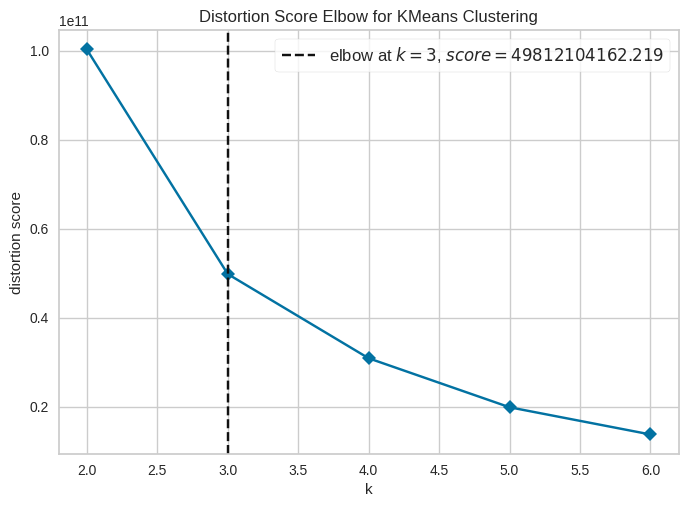

In [24]:

# Cria o modelo base
model = KMeans()

# Cria o visualizador do cotovelo
kmeans = KElbowVisualizer(model, k=clusters, timings=False)

# Ajusta aos dados
kmeans.fit(X)

# Exibe o gráfico
kmeans.show();


### 7.2. Silhouette Score ( SS )

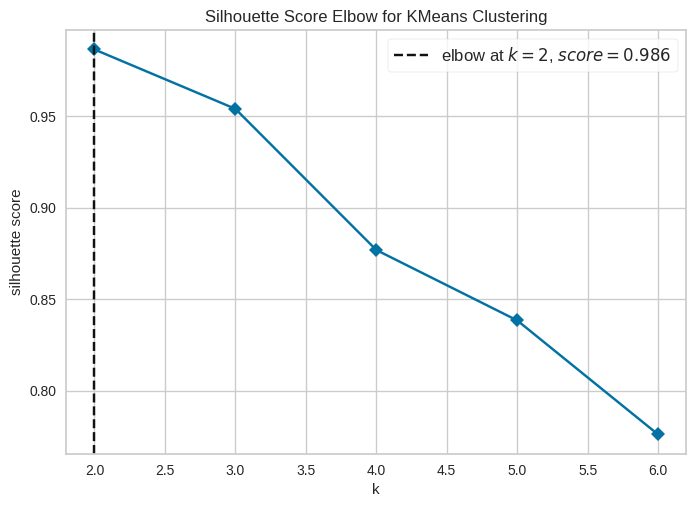

In [25]:
# Cria o modelo com o número de clusters ideal
kmeans = KElbowVisualizer( model, k=clusters,  metric='silhouette', timings=False)

# Ajusta aos dados
kmeans.fit(X)

# Exibe o gráfico
kmeans.show();

# <font color='red'>8.0. Model Training</font> 

### 8.1. K-Means

In [26]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# cluster labels
labels = kmeans.labels_


### 8.2. Cluster Validation

In [27]:
# WSS
print(f'WSS value: {kmeans.inertia_:.2f}')
# SS
print(f'SS value: {m .silhouette_score( X, labels, metric="euclidean" ) :.3f}')

WSS value: 53020543730.95


SS value: 0.949


# <font color='red'>9.0. Cluster Analysis</font> 

In [28]:
df9 = df6.copy()
df9['cluster'] = labels
# Visualize the clusters
df9.head()

,customer_id,gros_revenue,recence_days,invoice_no,cluster
0,17850,5288.63,302,312,0
1,13047,3079.10,31,196,0
2,12583,7187.34,2,251,0
3,13748,948.25,95,28,0
4,15100,635.10,330,6,0


### 9.1. Visualization Inspection

In [29]:
import nbformat
fig = px.scatter_3d(df9, x='gros_revenue', y='recence_days', z='invoice_no', color='cluster')

fig.show()

### 9.2. Cluster Profile

In [30]:
df9.head()

,customer_id,gros_revenue,recence_days,invoice_no,cluster
0,17850,5288.63,302,312,0
1,13047,3079.10,31,196,0
2,12583,7187.34,2,251,0
3,13748,948.25,95,28,0
4,15100,635.10,330,6,0


In [31]:
# Number od customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['%_customers'] = round( (df_cluster['customer_id'] / df_cluster['customer_id'].sum() ) * 100, 2 )

# Media de gros_revenue
df_avg_gros_revenue = round( df9[['gros_revenue', 'cluster']].groupby('cluster').mean().reset_index(), 2 )
df_cluster = df_cluster.merge(df_avg_gros_revenue, on='cluster', how='inner')

# Media de recence_days
df_avg_recence_days = round( df9[['recence_days', 'cluster']].groupby('cluster').mean().reset_index(), 2 )
df_cluster = df_cluster.merge(df_avg_recence_days, on='cluster', how='inner')

# Media de invoice_no
df_avg_invoice_no = round( df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index(), 0)
df_cluster = df_cluster.merge(df_avg_invoice_no, on='cluster', how='inner')
df_cluster.columns = ['cluster', 'n_customers', '%_customers', 'avg_gros_revenue', 'avg_recence_days', 'avg_invoice_no']
df_cluster = df_cluster.sort_values(by='cluster').reset_index(drop=True)
df_cluster

,cluster,n_customers,%_customers,avg_gros_revenue,avg_recence_days,avg_invoice_no
0,0,4335,99.15,1372.58,92.26,84.0
1,1,6,0.14,182181.98,7.17,1828.0
2,2,31,0.71,40543.52,13.29,1034.0


# <font color='red'>10.0. Deploy To Production</font> 